# Singapore rainfall analysis with ARMA

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pylab

import math
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm
from scipy.stats import anderson
from scipy.special import erf

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.diagnostic import het_arch

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [2]:
df2 = pd.read_csv('NFLX.csv')

# Data visualisation

# Data preparation

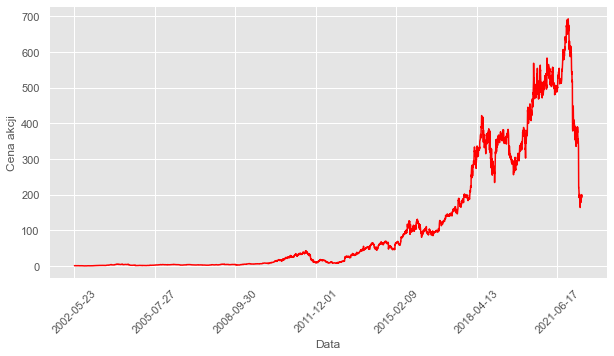

In [3]:
# date = df.month.values
# rainfall = df.total_rainfall.values
date = [*range(len(df2.Date.values))]
date2 = df2.Date.values
rainfall = df2.Open.values

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation = 45)
xloc = plt.MaxNLocator(9)
ax.xaxis.set_major_locator(xloc)
plt.plot(date2, rainfall, color = 'red')
plt.xlabel('Data')
plt.ylabel('Cena akcji')
plt.show()

### ACF, PACF for raw data

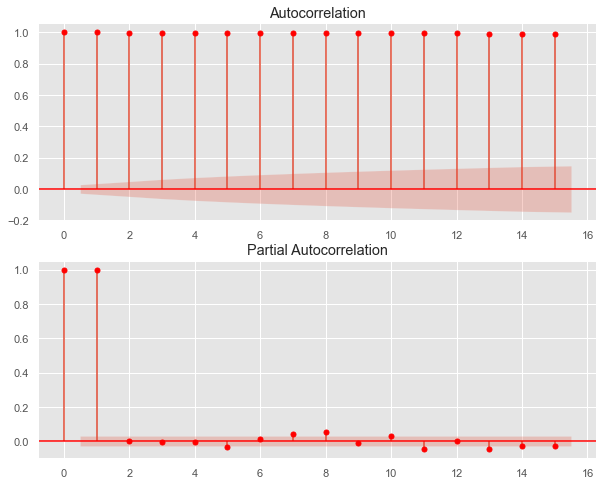

In [4]:
width = 10
height = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(rainfall, lags = 15, ax=ax[0], color = 'red')
plot_pacf(rainfall, lags = 15, ax=ax[1], method='ols', color = 'red')
plt.show()

### ADF test - for stationarity

In [5]:
def adf(data):
    adf = adfuller(data)
    print('Test statistic: ' +  str(adf[0]))
    print('P-value: ' +  str(adf[1]))

In [6]:
adf(rainfall)
print('Series is not stationary')

Test statistic: -1.3336726659953988
P-value: 0.6136297419105514
Series is not stationary


### Variance stabilization - Box-Cox Transformation

In [7]:
rainfall2, lmb = stats.boxcox(rainfall)

In [8]:
lmb

-0.02140962164007086

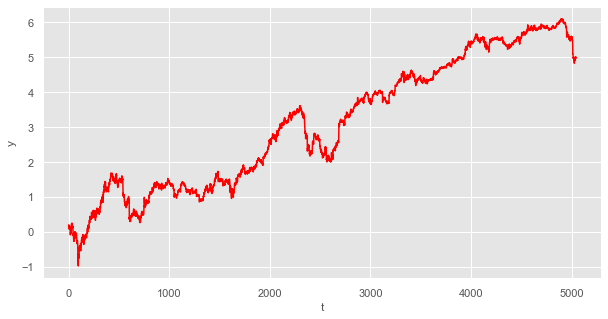

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(date, rainfall2, color = 'red')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [12]:
adf(rainfall2)
print('Series is not stationary')

Test statistic: -1.2386174750248522
P-value: 0.6567668529876127
Series is not stationary


### Histograms of data (before and after Box-Cox Transformation)

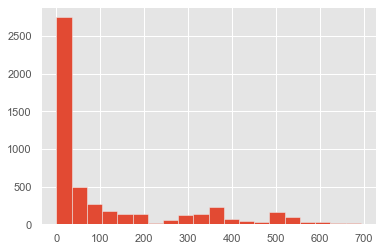

In [13]:
plt.hist(rainfall, bins = 20)
plt.show()

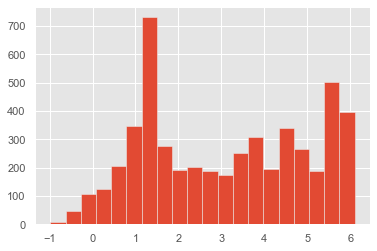

In [14]:
plt.hist(rainfall2, bins = 20)
plt.show()

### Trend decomposition

In [15]:
def trend(data):
    array1 = data[:1]
    array2 = data[1:] - data[:(len(data) - 1)]
    return np.array(list(array1) + list(array2))

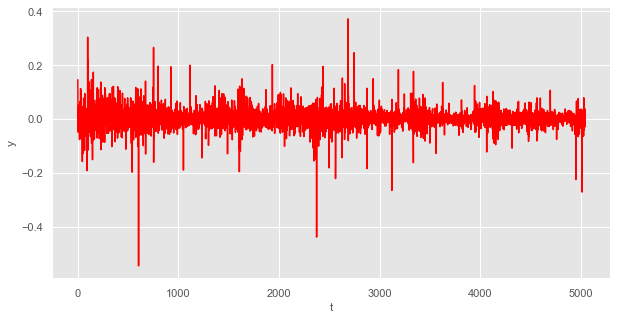

In [16]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
rainfall3 = trend(rainfall2)
plt.plot(date, rainfall3, color = 'red')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [17]:
adf(rainfall3)
print('Series is stationary')

Test statistic: -31.696922569094905
P-value: 0.0
Series is stationary


### Seasonality decomposition (it's not necessary, there is not visible seasonality)

In [18]:
def season(data, m = 365):
    array1 = data[:m]
    array2 = data[m:] - data[:(len(data) - m)]
    return np.array(list(array1) + list(array2))

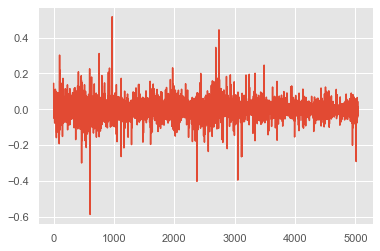

In [19]:
rainfall4 = season(rainfall3)
plt.plot(date, rainfall4)
plt.show()


In [20]:
adf(rainfall4)
print('Series is stationary')

Test statistic: -14.151956449583382
P-value: 2.1541229469805177e-26
Series is stationary


### ACF, PACF for decomposed data

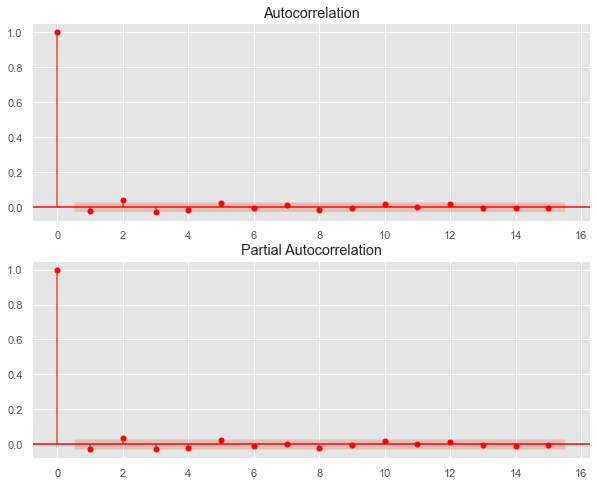

In [21]:
width = 10
height = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(rainfall3, lags = 15, ax=ax[0], color = 'red')
plot_pacf(rainfall3, lags = 15, ax=ax[1], method='ols', color = 'red')
plt.show()

# Fitting ARMA model

In [147]:
def fit_ARIMA(data, pmax = 10, qmax = 10, d = 0):
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

    rows = []
    best_params = 0
    best_aic = SARIMAX(data, order = (1, 1, 1)).fit(disp = -1).aic
    
    for q in range(1, qmax + 1):
        row = []
        for p in range(1, pmax + 1):
            params = (p, d, q)
            model = SARIMAX(data, order = params).fit(disp = -1)
            aic = model.aic
            row.append(aic)
            if aic < best_aic:
                best_aic = aic
                best_params = params
        rows.append(row)
        
    width = 10
    height = 7

    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
    sns.heatmap(rows, cmap = "BuPu", xticklabels=[*range(1, pmax + 1)], yticklabels=[*range(1, qmax + 1)], cbar_kws={'label': 'AIC', 
                                                                                                      'shrink' : 1.2})
    plt.ylim(0, qmax)
    plt.xlabel('p', fontsize = 15)
    plt.ylabel('q', fontsize = 15)
    plt.show()
    return best_params

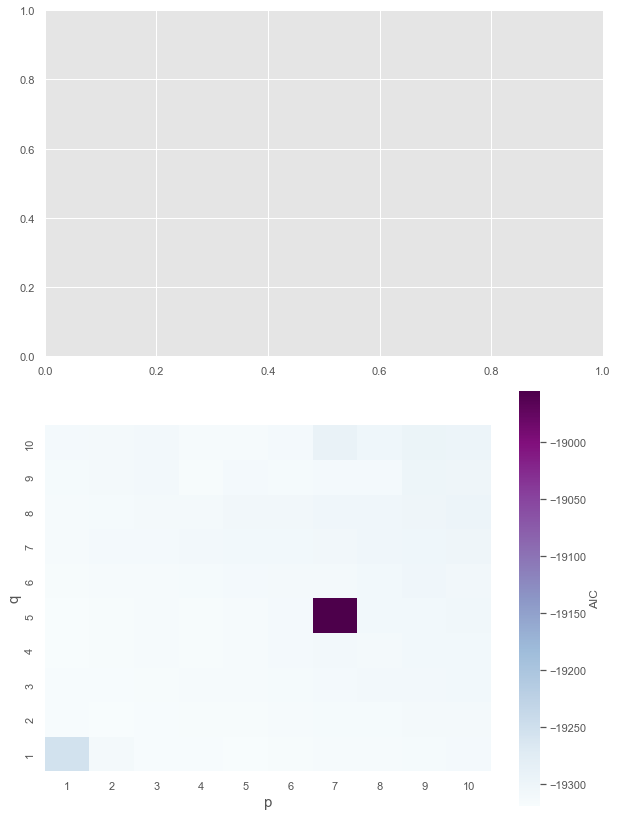

(1, 0, 4)


In [148]:
x = fit_ARIMA(rainfall3)
print(x)

### Best model summary

In [29]:
best_model = SARIMAX(rainfall3, order=(1, 0, 4)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5044
Model:               SARIMAX(1, 0, 4)   Log Likelihood                9665.668
Date:                Thu, 09 Feb 2023   AIC                         -19319.335
Time:                        13:17:29   BIC                         -19280.180
Sample:                             0   HQIC                        -19305.618
                               - 5044                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4624      0.360     -1.283      0.199      -1.169       0.244
ma.L1          0.4389      0.360      1.218      0.223      -0.267       1.145
ma.L2          0.0272      0.014      1.931      0.0

# Rating our ARMA model

### Generating ARMA realisation

In [30]:
x = rainfall3

In [31]:
data = best_model.params
data
phi = data[0]
theta1 = data[1]
theta2 = data[2]
theta3 = data[3]
theta4 = data[4]
sigma2 = data[5]
ar1 = np.array([phi])
ma4 = np.array([theta1, theta2, theta3, theta4])

In [32]:
Y = ArmaProcess(ar1, ma4).generate_sample(nsample = len(x), scale = math.sqrt(sigma2))

In [33]:
Y

array([0.01332944, 0.05825216, 0.01308185, ..., 0.00280794, 0.01103271,
       0.04762049])

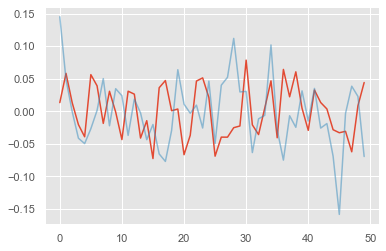

In [34]:
plt.plot(date[:50], Y[:50])
plt.plot(date[:50], x[:50], alpha = 0.5)
plt.show()

### Confidence intervals

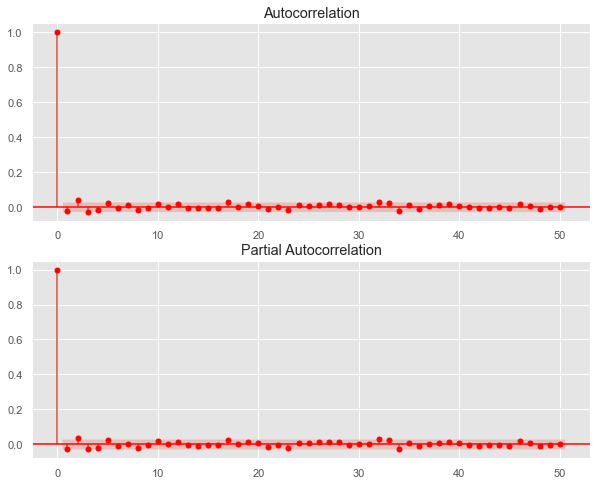

In [54]:
width = 10
height = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
# acf, confidence_interval=sm.tsa.acf(x - Y, nlags = 50, alpha=0.05, fft=False)
# pacf, confidence_interval=sm.tsa.pacf(x - Y, nlags = 50, alpha=0.05)
plot_acf(rainfall3, lags = 50, ax=ax[0], color = 'red')
plot_pacf(rainfall3, lags = 50, ax=ax[1], color = 'red')
plt.show()

### De-decomposition :)

In [56]:
def inv(data, lmb, x0 = rainfall3[0]):
    Xt = []
    for y in data:
        x = y + x0
        Xt.append(x)
        x0 = x
    Xt = np.array(Xt)
    if lmb == 0:
        Xt = np.exp(Xt)
    else:
        Xt = np.exp(np.log(lmb*Xt+1)/lmb)
    return [*range(len(Xt))], Xt

In [57]:
a, b = inv(rainfall3, lmb)

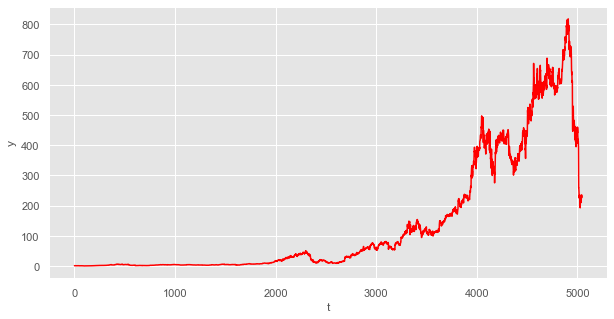

In [58]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(a, b, color = 'red')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

In [59]:
Y = ArmaProcess(ar1, ma4).generate_sample(nsample = len(x), scale = math.sqrt(sigma2))

In [69]:
c, d = inv(best_model.predict(start=0, end=1000), lmb)
c, d = c, d[::-1]
d

array([1.10082673, 1.10254789, 1.10201742, ..., 1.15708985, 1.1522238 ,
       1.156429  ])

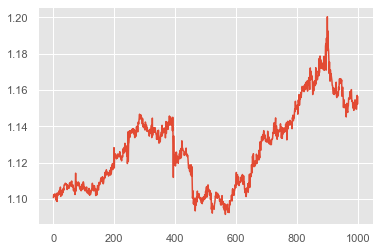

In [70]:
plt.plot(c, d)
plt.show()

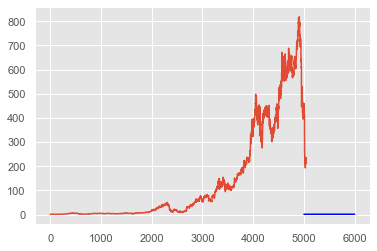

In [72]:
plt.plot(a, b)
plt.plot([*range(5000, 6001)], d, color = 'blue')

### Compare trajectory with quantile lines

In [46]:
def quantile_lines(alpha):
    Q_downs = []
    Q_ups = []
    for i in range(100):
        Y = ArmaProcess(ar1, ma4).generate_sample(nsample = len(x), scale = math.sqrt(sigma2))
#         date, Y = inv(Y, lmb)
        Q_down = []
        Q_up = []
        for time in Y:
            q_down = np.quantile(Y, alpha/2)
            q_up = np.quantile(Y, 1 - alpha/2)
            Q_down.append(q_down)
            Q_up.append(q_up)
        q_down = np.mean(Q_down)
        q_up = np.mean(Q_up)
        Q_downs.append(q_down)
        Q_ups.append(q_up)
    return Q_downs, Q_ups, date

In [47]:
quantile_lines = quantile_lines(0.05)
q_down = np.array(quantile_lines[0])
q_up = np.array(quantile_lines[1])

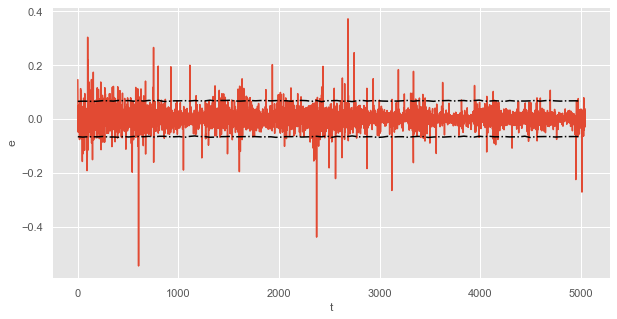

In [52]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(quantile_lines[2], x)
plt.plot(np.linspace(0, 5000, 100), q_up, color = 'black', linestyle = 'dashdot')
plt.plot(np.linspace(0, 5000, 100), q_down, color = 'black', linestyle = 'dashdot')
plt.xlabel('t')
plt.ylabel('e')
plt.show()

### Prediction

# Residuum analysis

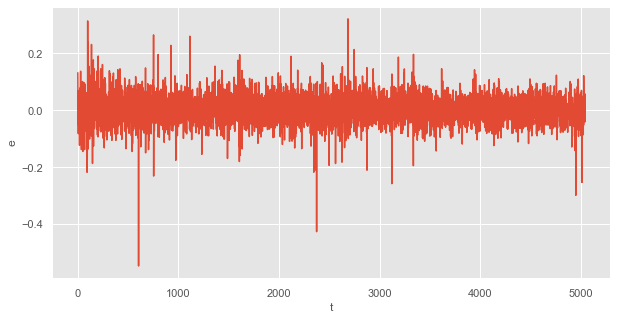

In [35]:
res = x-Y
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
plt.plot(date, x - Y)
plt.xlabel('t')
plt.ylabel('e')
plt.show()

### Mean testing - t test

In [36]:
p = []
for i in range(1000):
    Y1 = ArmaProcess(ar1, ma4).generate_sample(nsample = len(x), scale = math.sqrt(sigma2))
    Y2 = ArmaProcess(ar1, ma4).generate_sample(nsample = len(x), scale = math.sqrt(sigma2))
    pvalue = ttest_ind(x - Y1, x - Y2)[1]
    p.append(pvalue)
p = np.mean(p)
p

0.6431889446286978

### Variance testing - Arch test

In [37]:
arch = []
for i in range(5000):
    Y = ArmaProcess(ar1, ma4).generate_sample(nsample = len(x), scale = math.sqrt(sigma2))
    res = x - Y
    het = het_arch(res, nlags = 100, ddof = 1 + 4)[1] #p-value of LM test statistic
    arch.append(het)
np.mean(het)

0.2584876713457704

### Independence testing - Ljung-Box test

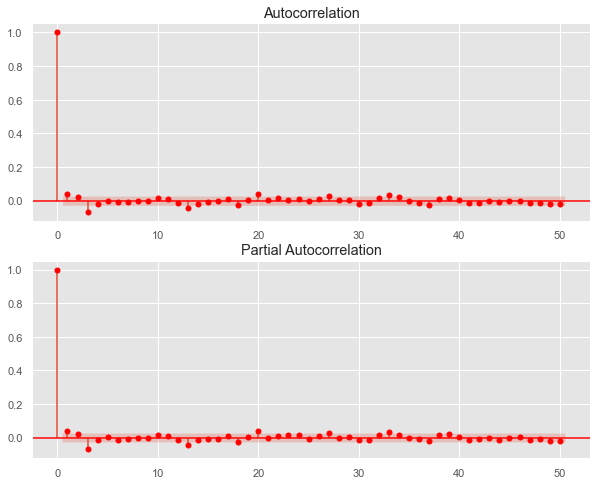

In [53]:
width = 10
height = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
# acf, confidence_interval=sm.tsa.acf(x - Y, nlags = 50, alpha=0.05, fft=False)
# pacf, confidence_interval=sm.tsa.pacf(x - Y, nlags = 50, alpha=0.05)
plot_acf(x - Y, lags = 50, ax=ax[0], color = 'red')
plot_pacf(x - Y, lags = 50, ax=ax[1], color = 'red')
plt.show()

In [38]:
pvalues = sm.stats.acorr_ljungbox(res, lags=[100], return_df=True)
pvalues

,lb_stat,lb_pvalue
100,153.910577,0.000434


### Normality testing

#### ECDF, CDF

In [39]:
def cdf(x, mi, sigma):
    x = np.array(sorted(x))
    y = 1/2*(1 + erf((x - mi)/sigma*math.sqrt(2)))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(x, y, color = 'black', label = 'CDF', linestyle = 'dashdot')
    sns.ecdfplot(data = rainfall3, color = 'red', label = 'ECDF')
    plt.xlabel('e')
    plt.ylabel('F(e)')
    plt.legend()
    plt.show()

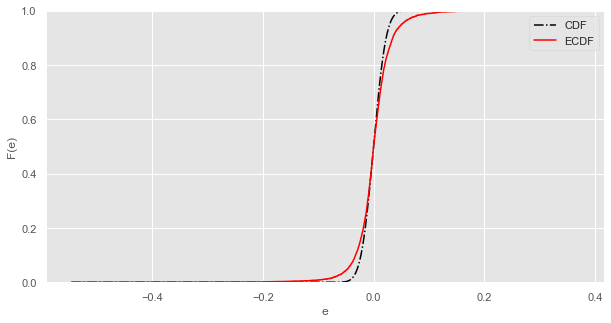

In [40]:
cdf(x, 0, math.sqrt(sigma2))

#### Histogram and density plot

In [41]:
res = x - Y

In [44]:
def norm_kde(x, mi, sigma):
    x = np.array(sorted(x))
    y = 1/(math.sqrt(2*math.pi)*sigma)*np.exp(-(x - mi)**2/(2*sigma**2))
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1) 
    plt.plot(x, y, color = 'blue', label = 'PDF')
    plt.hist(res, bins = 80, density = True, color = 'red', ec = 'black', label = 'Histogram szumu')
    plt.xlabel('e')
    plt.ylabel('f(e)')
    plt.legend()
    plt.show()

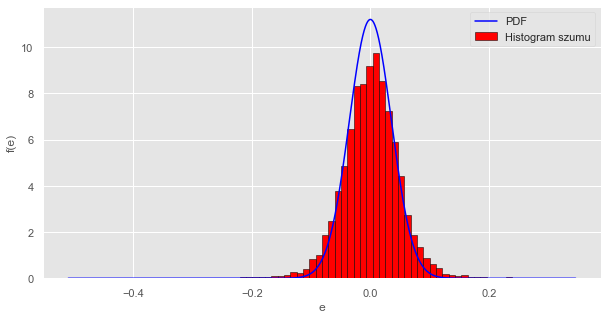

In [45]:
norm_kde(res, 0, math.sqrt(sigma2))

#### qq-plot

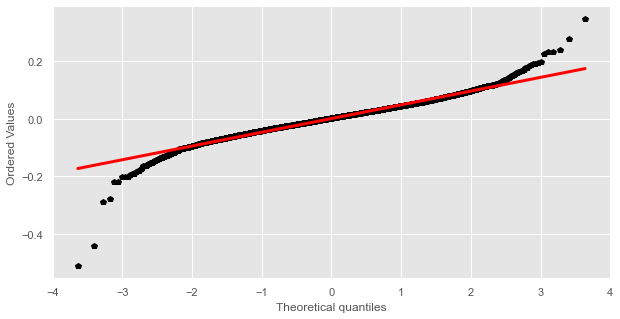

In [43]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
stats.probplot(res, dist="norm", plot=pylab)
ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('black')
ax.get_lines()[0].set_markeredgecolor('black')
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linewidth(3)
ax.set_title('')
pylab.show()

#### Anderson-Darling test

In [76]:
ad = anderson(res)
ad

AndersonResult(statistic=11.357783789566383, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

# Conclusion

# References

https://www.statology.org/dickey-fuller-test-python/

https://www.statology.org/ljung-box-test-python/#:~:text=To%20perform%20the%20Ljung-Box%20test%20on%20a%20data,returns%20a%20test%20statistic%20and%20a%20corresponding%20p-value.

https://el.us.edu.pl/ekonofizyka/index.php/Analiza_Szereg%C3%B3w_Czasowych/Dekompozycja_szeregu_czasowego#Metoda_S3:_R.C3.B3.C5.BCnicowanie_z_przesuni.C4.99ciem_d

https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/

https://www.geeksforgeeks.org/how-to-perform-an-anderson-darling-test-in-python/